# Обратное распространение ошибки в многослойных сетях

### Цели: 
- реализация градиентного спуска в `Numpy`

### Датасет:
- Digits: 10 классов изображений рукописных цифр
- [sklearn.datasets.load_digits](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits

digits = load_digits()

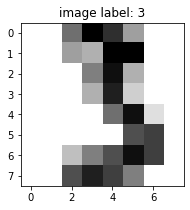

In [ ]:
sample_index = 45
plt.figure(figsize=(3, 3))
plt.imshow(digits.images[sample_index], cmap=plt.cm.gray_r,
           interpolation='nearest')
plt.title("image label: %d" % digits.target[sample_index]);

### Предобработка

- Нормализация
- Разделение выборки

In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

data = np.asarray(digits.data, dtype='float32')
target = np.asarray(digits.target, dtype='int32')

X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.15, random_state=37)

# mean = 0 ; standard deviation = 1.0
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# print(scaler.mean_)
# print(scaler.scale_)

In [ ]:
X_train.shape

(1527, 64)

In [ ]:
X_train.dtype

dtype('float32')

In [ ]:
X_test.shape

(270, 64)

In [ ]:
y_train.shape

(1527,)

In [ ]:
y_train.dtype

dtype('int32')

# Реализация в NumPy

## a) Логистическая регрессия

В этом разделе мы реализуем модель логистической регрессии, которую можно обучать с помощью SGD с использованием numpy. 
Цели:

- Реализовать простую прямую модель без скрытого слоя (эквивалентно логистической регрессии):

примечание: важны форма (shape), транспонирование весов W относительно цели
$y = softmax(\mathbf{W} \dot x + b)$

- Создать функцию прогнозирования, которая возвращает наиболее вероятный класс с учетом входных данных $x$

- Создать функцию оценки точности для пакета входных данных $X$ и соответствующих ожидаемых результатов $y_{true}$

- Создать функцию градиента, которая вычисляет $\frac{d}{dW} -\log(softmax(W \dot x + b))$ для $x$ и соответствующих ожидаемых результатов $y_{true}$ ; убедиться, что градиенты хорошо определены

- Создайте функцию обучения, которая использует вывод функции градиента для обновления $\mathbf{W}$ и $b$


### Горячее кодирование (one-hot) данных метки класса

Сначала давайте определим вспомогательную функцию для вычисления одного горячего кодирования целочисленного массива для фиксированного числа классов (аналогично keras' `to_categorical`):

In [ ]:
def one_hot(n_classes, y):
    return np.eye(n_classes)[y]

In [ ]:
one_hot(n_classes=10, y=3)

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [ ]:
one_hot(n_classes=10, y=[0, 4, 9, 1])

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

### Активация softmax

Теперь давайте реализуем векторную функцию softmax:

$$
softmax(\mathbf{x}) = \frac{1}{\sum_{i=1}^{n}{e^{x_i}}}
\cdot
\begin{bmatrix}
  e^{x_1}\\\\
  e^{x_2}\\\\
  \vdots\\\\
  e^{x_n}
\end{bmatrix}
$$

In [ ]:
def softmax(x):
    return np.exp(x) / np.exp(x).sum(axis=0,keepdims=True)

Убедитесь, что это работает по произвольному вектору (и убедитесь, что сумма компонентов равна единице):

In [ ]:
print(softmax([10, 2, -3]))

[9.99662391e-01 3.35349373e-04 2.25956630e-06]


In [ ]:
print(np.sum(softmax([10, 2, -3])))

1.0


Обратите внимание, что наивная реализация softmax может быть не в состоянии обработать пакет активаций за один вызов:

In [ ]:
X = np.array([[10, 2, -3],
              [-1, 5, -20]])
print(softmax(X))

[[9.99983299e-01 4.74258732e-02 9.99999959e-01]
 [1.67014218e-05 9.52574127e-01 4.13993755e-08]]


Вот способ реализации softmax, который работает как для отдельного вектора активаций, так и для партии векторов активаций сразу:

In [ ]:
def softmax(X):
    exp = np.exp(X)
    return exp / np.sum(exp, axis=-1, keepdims=True)


print("softmax of a single vector:")
print(softmax([10, 2, -3]))

softmax of a single vector:
[9.99662391e-01 3.35349373e-04 2.25956630e-06]


Вероятности должны в сумме равняться 1:

In [ ]:
print(np.sum(softmax([10, 2, -3, 4])))

1.0


In [ ]:
print("sotfmax of 2 vectors:")
X = np.array([[10, 2, -3],
              [-1, 5, -20]])
print(softmax(X))

sotfmax of 2 vectors:
[[9.99662391e-01 3.35349373e-04 2.25956630e-06]
 [2.47262316e-03 9.97527377e-01 1.38536042e-11]]


Сумма вероятностей для каждого входного вектора логитов должна быть равна 1:

In [ ]:
print(np.sum(softmax(X), axis=1))

[1. 1.]


Реализуйте функцию, которая получает истинный класс с горячим кодированием `Y_true` и некоторые предсказанные вероятности `Y_pred`, а возвращает отрицательную логарифмическую вероятность.

In [ ]:
def nll(Y_true, Y_pred):
    Y_true = np.asarray(Y_true)
    Y_pred = np.asarray(Y_pred)
    
    # Ваше решение
    return -np.sum(Y_true*np.log(Y_pred+0.0000001)+(1-Y_true)*np.log(1-Y_pred+0.0000001), axis=-1, keepdims=True)


# Убедитесь, что он работает для простого образца 
print(nll([1, 0, 0], [0.99, 0.01, 0]))

0.020100570696907044


Убедитесь, что nll очень уверенного, но плохого прогноза намного выше положительного числа:

In [ ]:
print(nll([1, 0, 0], [0.01, 0.01, .98]))

8.527233527319737


Убедитесь, что ваша реализация может вычислить среднюю отрицательную логарифмическую вероятность группы прогнозов: `Y_pred` и `Y_true`, следовательно, могут быть представлены как 2D-массивы:

In [ ]:
def nll(Y_true, Y_pred):
    Y_true = np.atleast_2d(Y_true)
    Y_pred = np.atleast_2d(Y_pred)
    nll = -np.sum(np.log(Y_pred+0.0000001)*Y_true,axis=1)
    return nll.mean()

In [ ]:
# Убедитесь, что средний NLL следующих 3 почти идеален
# предсказания близки к 0
Y_true = np.array([[0, 1, 0],
                   [1, 0, 0],
                   [0, 0, 1]])

Y_pred = np.array([[0,   1,    0],
                   [0.99, 0.01, 0],
                   [0,   0,    1]])

print(nll(Y_true, Y_pred))

0.003350011614471826


Давайте теперь изучим следующую линейную модель, обучаемую SGD, **один образец за один раз**.

In [ ]:
class LogisticRegression():

    def __init__(self, input_size, output_size):
        self.W = np.random.uniform(size=(input_size, output_size),
                                   high=0.1, low=-0.1)
        self.b = np.random.uniform(size=output_size,
                                   high=0.1, low=-0.1)
        self.output_size = output_size
        
    def forward(self, X):
        Z = np.dot(X, self.W) + self.b
        return softmax(Z)
    
    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)
    
    def grad_loss(self, x, y_true):
        y_pred = self.forward(x)
        dnll_output =  y_pred - one_hot(self.output_size, y_true)
        grad_W = np.outer(x, dnll_output)
        grad_b = dnll_output
        grads = {"W": grad_W, "b": grad_b}
        return grads
    
    def train(self, x, y, learning_rate):
        # Традиционное обновление SGD без momentum
        grads = self.grad_loss(x, y)
        self.W = self.W - learning_rate * grads["W"]
        self.b = self.b - learning_rate * grads["b"]      
        
    def loss(self, X, y):
        return nll(one_hot(self.output_size, y), self.forward(X))

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)

In [ ]:
# Создайте модель и проверьте ее прямой вывод
n_features = X_train.shape[1]
n_classes = len(np.unique(y_train))
lr = LogisticRegression(n_features, n_classes)

print("Evaluation of the untrained model:")
train_loss = lr.loss(X_train, y_train)
train_acc = lr.accuracy(X_train, y_train)
test_acc = lr.accuracy(X_test, y_test)

print("train loss: %0.4f, train acc: %0.3f, test acc: %0.3f"
      % (train_loss, train_acc, test_acc))

Evaluation of the untrained model:
train loss: 2.3151, train acc: 0.109, test acc: 0.115


Оцените случайно инициализированную модель на первом примере:

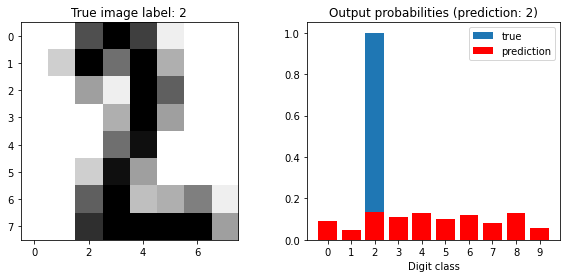

In [ ]:
def plot_prediction(model, sample_idx=0, classes=range(10)):
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    ax0.imshow(scaler.inverse_transform(X_test[sample_idx:sample_idx+1]).reshape(8, 8),
               cmap=plt.cm.gray_r, interpolation='nearest')
    ax0.set_title("True image label: %d" % y_test[sample_idx]);


    ax1.bar(classes, one_hot(len(classes), y_test[sample_idx]), label='true')
    ax1.bar(classes, model.forward(X_test[sample_idx]), label='prediction', color="red")
    ax1.set_xticks(classes)
    prediction = model.predict(X_test[sample_idx])
    ax1.set_title('Output probabilities (prediction: %d)'
                  % prediction)
    ax1.set_xlabel('Digit class')
    ax1.legend()
    
plot_prediction(lr, sample_idx=0)

In [ ]:
# Обучение на одну эпоху
learning_rate = 0.01

for i, (x, y) in enumerate(zip(X_train, y_train)):
    lr.train(x, y, learning_rate)
    if i % 100 == 0:
        train_loss = lr.loss(X_train, y_train)
        train_acc = lr.accuracy(X_train, y_train)
        test_acc = lr.accuracy(X_test, y_test)
        print("Update #%d, train loss: %0.4f, train acc: %0.3f, test acc: %0.3f"
              % (i, train_loss, train_acc, test_acc))

Update #0, train loss: 2.2850, train acc: 0.137, test acc: 0.144
Update #100, train loss: 1.2966, train acc: 0.737, test acc: 0.748
Update #200, train loss: 0.8646, train acc: 0.847, test acc: 0.867
Update #300, train loss: 0.6400, train acc: 0.898, test acc: 0.874
Update #400, train loss: 0.5425, train acc: 0.900, test acc: 0.900
Update #500, train loss: 0.4719, train acc: 0.911, test acc: 0.907
Update #600, train loss: 0.4116, train acc: 0.923, test acc: 0.930
Update #700, train loss: 0.3733, train acc: 0.929, test acc: 0.941
Update #800, train loss: 0.3517, train acc: 0.932, test acc: 0.941
Update #900, train loss: 0.3275, train acc: 0.931, test acc: 0.941
Update #1000, train loss: 0.3034, train acc: 0.938, test acc: 0.948
Update #1100, train loss: 0.2836, train acc: 0.944, test acc: 0.948
Update #1200, train loss: 0.2726, train acc: 0.947, test acc: 0.963
Update #1300, train loss: 0.2641, train acc: 0.948, test acc: 0.944
Update #1400, train loss: 0.2492, train acc: 0.952, test acc

Оцените обученную модель на первом примере:

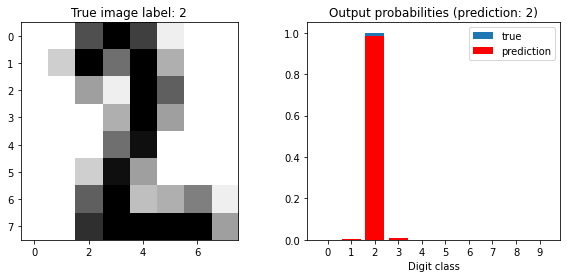

In [ ]:
plot_prediction(lr, sample_idx=0)

## b) Прямое распространение

Цель этого раздела — реализовать алгоритм обратного распространения ошибки (SGD с цепным правилом) в однослойной нейронной сети с использованием сигмовидной функции активации.
Задача:
- Реализовать  `sigmoid` и его поэлементные производные `dsigmoid`:

$$
sigmoid(x) = \frac{1}{1 + e^{-x}}
$$

$$
dsigmoid(x) = sigmoid(x) \cdot (1 - sigmoid(x))
$$

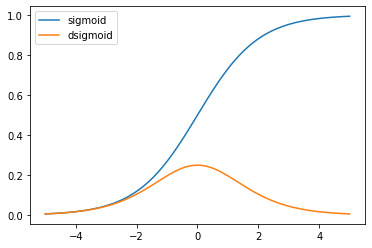

In [ ]:
def sigmoid(X):
    # Ваше решение
    return 1 / (1 + np.exp(-X))


def dsigmoid(X):
    sig=sigmoid(X)
    return sig * (1 - sig)


x = np.linspace(-5, 5, 100)
plt.plot(x, sigmoid(x), label='sigmoid')
plt.plot(x, dsigmoid(x), label='dsigmoid')
plt.legend(loc='best');

- Реализовать `forward` и `forward_keep_all` функции для модели со скрытым слоем с сигмовидной функцией активации:
  - $\mathbf{h} = sigmoid(\mathbf{W}^h \mathbf{x} + \mathbf{b^h})$
  - $\mathbf{y} = softmax(\mathbf{W}^o \mathbf{h} + \mathbf{b^o})$

- Примечания: 
  - старайтесь, чтобы код был максимально похож на предыдущий;
  - `forward` теперь имеет параметр сохранения активаций, чтобы также возвращать скрытые активации и предварительные активации;

- Обновите функцию grad, чтобы вычислить все градиенты; убедитесь, что градиенты хорошо определены;

- Реализуйте функции `train` и `loss`.

**Бонус**: повторная реализация всего с нуля, но без рассмотрения решения «логистической регрессии» — отличное упражнение.

In [ ]:
EPSILON = 1e-8


class NeuralNet():
    """MLP с 1 скрытым слоем с сигмоидной активацией"""
    
    def __init__(self, input_size, hidden_size, output_size):
        # Ваше решение
        self.W_h = np.random.uniform(size=(input_size, hidden_size), high=0.01, low=-0.01)
        self.b_h = np.zeros(hidden_size)
        self.W_o = np.random.uniform(
            size=(hidden_size, output_size), high=0.01, low=-0.01)
        self.b_o = np.zeros(output_size)
        self.output_size = output_size
            
    def forward_keep_activations(self, X):
        # Ваше решение
        z_h = np.dot(X, self.W_h) + self.b_h
        h = sigmoid(z_h)
        z_o = np.dot(h, self.W_o) + self.b_o
        y = softmax(z_o)
        return y, h, z_h

    def forward(self, X):
        h = sigmoid(np.dot(X, self.W_h) + self.b_h)
        y = softmax(np.dot(h, self.W_o) + self.b_o)
        return y

    def loss(self, X, y):
        # Ваше решение
        return nll(one_hot(self.output_size, y), self.forward(X))

    def grad_loss(self, x, y_true):
        # Ваше решение
        y, h, z_h = self.forward_keep_activations(x)
        grad_z_o = y - one_hot(self.output_size, y_true)

        grad_W_o = np.outer(h, grad_z_o)
        grad_b_o = grad_z_o
        grad_h = np.dot(grad_z_o, np.transpose(self.W_o))
        grad_z_h = grad_h * dsigmoid(z_h)
        grad_W_h = np.outer(x, grad_z_h)
        grad_b_h = grad_z_h
        return {"W_h": grad_W_h, "b_h": grad_b_h, "W_o": grad_W_o, "b_o": grad_b_o}

    def train(self, x, y, learning_rate):
        # Ваше решение
        grads = self.grad_loss(x, y)
        self.W_h = self.W_h - learning_rate * grads["W_h"]
        self.b_h = self.b_h - learning_rate * grads["b_h"]
        self.W_o = self.W_o - learning_rate * grads["W_o"]
        self.b_o = self.b_o - learning_rate * grads["b_o"]

    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)

In [ ]:
n_hidden = 10
model = NeuralNet(n_features, n_hidden, n_classes)

In [ ]:
model.loss(X_train, y_train)

2.3025607330760147

In [ ]:
model.accuracy(X_train, y_train)

0.10019646365422397

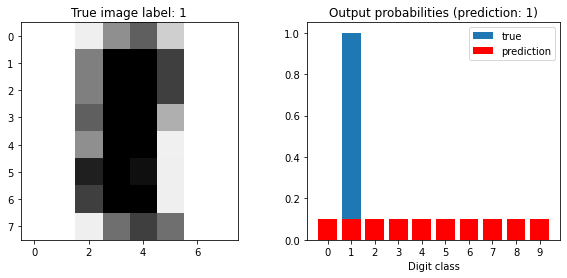

In [ ]:
plot_prediction(model, sample_idx=5)

In [ ]:
losses, accuracies, accuracies_test = [], [], []
losses.append(model.loss(X_train, y_train))
accuracies.append(model.accuracy(X_train, y_train))
accuracies_test.append(model.accuracy(X_test, y_test))

print("Random init: train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
      % (losses[-1], accuracies[-1], accuracies_test[-1]))

for epoch in range(15):
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        model.train(x, y, 0.1)

    losses.append(model.loss(X_train, y_train))
    accuracies.append(model.accuracy(X_train, y_train))
    accuracies_test.append(model.accuracy(X_test, y_test))
    print("Epoch #%d, train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
          % (epoch + 1, losses[-1], accuracies[-1], accuracies_test[-1]))

Random init: train loss: 2.30256, train acc: 0.100, test acc: 0.107
Epoch #1, train loss: 0.44369, train acc: 0.864, test acc: 0.804
Epoch #2, train loss: 0.19883, train acc: 0.949, test acc: 0.911
Epoch #3, train loss: 0.14788, train acc: 0.965, test acc: 0.933
Epoch #4, train loss: 0.12730, train acc: 0.973, test acc: 0.937
Epoch #5, train loss: 0.08740, train acc: 0.980, test acc: 0.937
Epoch #6, train loss: 0.07132, train acc: 0.985, test acc: 0.948
Epoch #7, train loss: 0.05481, train acc: 0.993, test acc: 0.959
Epoch #8, train loss: 0.05453, train acc: 0.991, test acc: 0.956
Epoch #9, train loss: 0.04548, train acc: 0.991, test acc: 0.967
Epoch #10, train loss: 0.04061, train acc: 0.994, test acc: 0.967
Epoch #11, train loss: 0.03359, train acc: 0.996, test acc: 0.970
Epoch #12, train loss: 0.02978, train acc: 0.997, test acc: 0.974
Epoch #13, train loss: 0.02756, train acc: 0.997, test acc: 0.967
Epoch #14, train loss: 0.02548, train acc: 0.997, test acc: 0.967
Epoch #15, train 

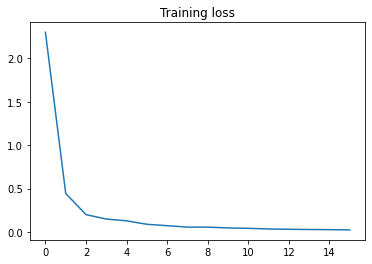

In [ ]:
plt.plot(losses)
plt.title("Training loss");

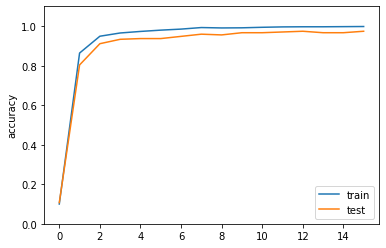

In [ ]:
plt.plot(accuracies, label='train')
plt.plot(accuracies_test, label='test')
plt.ylim(0, 1.1)
plt.ylabel("accuracy")
plt.legend(loc='best');

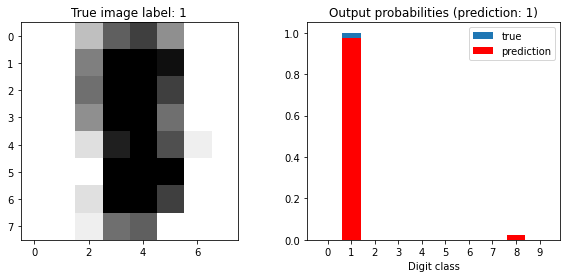

In [ ]:
plot_prediction(model, sample_idx=4)

## c) Упражнения

### Посмотрите на худшие ошибки предсказания

- Используйте numpy, чтобы найти тестовые образцы, для которых модель сделала худшие прогнозы,
- Используйте `plot_prediction` посмотреть на предсказания модели по этим образцам
- Вы бы могли сделать лучше?

test losses: [1.29287946 1.59110856 2.44778455 3.70736173 5.43738479]


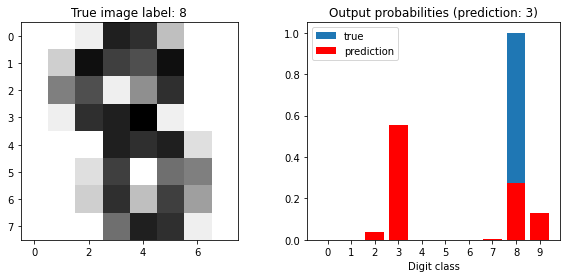

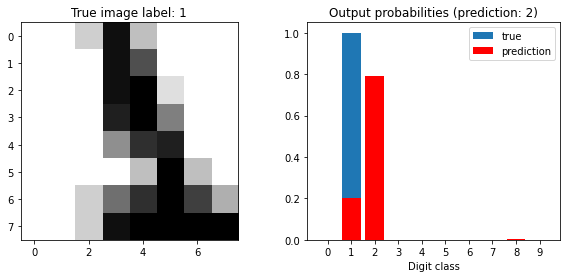

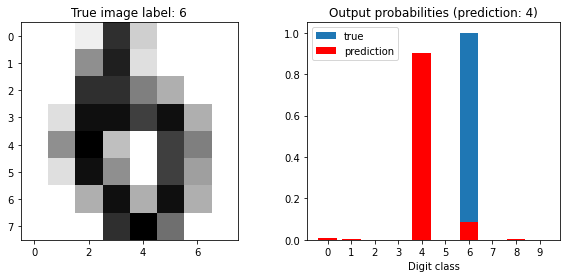

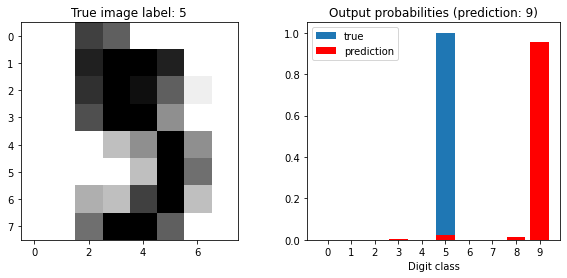

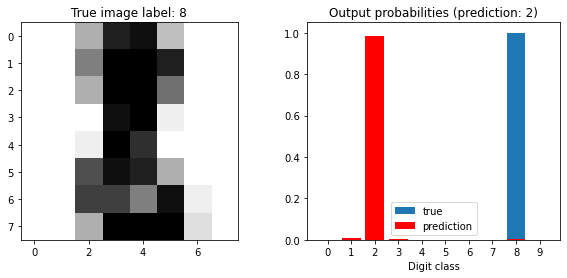

In [ ]:
# Ваше решение
test_losses = -np.sum(np.log(EPSILON + model.forward(X_test))* one_hot(10, y_test), axis=1)
worst= test_losses.argsort()[-5:]
print("test losses:", test_losses[worst])
for i in worst:
    plot_prediction(model, sample_idx=i)

### Настройки гиперпараметров

- Экспериментируйте с различными гиперпараметрами:
  - скорость обучения,
  - размер скрытого слоя,
  - схема инициализации: тест с 0 инициализацией против униформ-инициализации,
  - посмотрите другие функции активации,
  - добавьте второй скрытый слой.


### Мини-батчи

- Текущие реализации `train` и `grad_loss` в настоящее время принимают только один образец за раз:
    - реализовать поддержку обучения с мини-партией из 32 образцов за раз вместо одного,
    - поэкспериментируйте с разными размерами партий,
    - контролировать норму средних градиентов на полной обучающей выборке в конце каждой эпохи.


### Импульс

- Бонус: Реализуйте Momentum


### Вернемся в Keras

- Реализуйте ту же сетевую архитектуру с Keras;

- Убедитесь, что модель Keras может приблизительно воспроизводить поведение модели Numpy при использовании аналогичных значений гиперпараметров (размер модели, тип активации, значение скорости обучения и использование импульса);

- Вычислите отрицательную логарифмическую вероятность выборки 42 в тестовом наборе (можно использовать `model.predict_proba`);

- Вычислите среднее отрицательное логарифмическое правдоподобие на полном наборе тестов.

- Является ли модель переобученной или недообученной? (убедитесь, что модель полностью сошлась, увеличив количество эпох до 50 или более, если необходимо).

In [ ]:
#Ваше решение

Random init: train loss: 2.30262, train acc: 0.100, test acc: 0.107
Epoch #1, train loss: 2.28636, train acc: 0.179, test acc: 0.137
Epoch #2, train loss: 1.90972, train acc: 0.289, test acc: 0.237
Epoch #3, train loss: 1.40132, train acc: 0.651, test acc: 0.622
Epoch #4, train loss: 1.04984, train acc: 0.750, test acc: 0.719
Epoch #5, train loss: 0.81676, train acc: 0.836, test acc: 0.804
Epoch #6, train loss: 0.64882, train acc: 0.879, test acc: 0.841
Epoch #7, train loss: 0.52246, train acc: 0.908, test acc: 0.878
Epoch #8, train loss: 0.42778, train acc: 0.929, test acc: 0.893
Epoch #9, train loss: 0.35811, train acc: 0.942, test acc: 0.919
Epoch #10, train loss: 0.30693, train acc: 0.950, test acc: 0.930
Epoch #11, train loss: 0.26878, train acc: 0.958, test acc: 0.926
Epoch #12, train loss: 0.23960, train acc: 0.965, test acc: 0.926
Epoch #13, train loss: 0.21666, train acc: 0.969, test acc: 0.930
Epoch #14, train loss: 0.19815, train acc: 0.974, test acc: 0.937
Epoch #15, train 

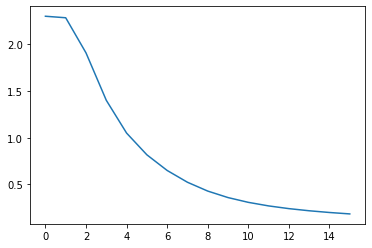

In [ ]:
# lr = 0.01

n_features = X_train.shape[1]
n_classes = len(np.unique(y_train))
n_hidden = 10
model = NeuralNet(n_features, n_hidden, n_classes)
losses, accuracies, accuracies_test = [], [], []
losses.append(model.loss(X_train, y_train))
accuracies.append(model.accuracy(X_train, y_train))
accuracies_test.append(model.accuracy(X_test, y_test))

print("Random init: train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
      % (losses[-1], accuracies[-1], accuracies_test[-1]))

for epoch in range(15):
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        model.train(x, y, 0.01)

    losses.append(model.loss(X_train, y_train))
    accuracies.append(model.accuracy(X_train, y_train))
    accuracies_test.append(model.accuracy(X_test, y_test))
    print("Epoch #%d, train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
          % (epoch + 1, losses[-1], accuracies[-1], accuracies_test[-1]))
plt.plot(losses)

Text(0, 0.5, 'accuracy')

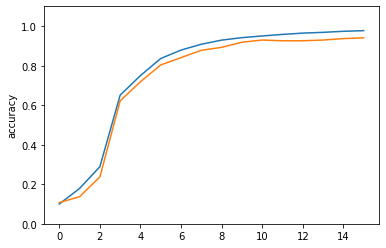

In [ ]:
plt.plot(accuracies, label='train')
plt.plot(accuracies_test, label='test')
plt.ylim(0, 1.1)
plt.ylabel("accuracy")

Learning rait=0.01
малый Learning rait позволяет увеличичть точность модели, однако при слишком малом значении изменения в модели могут идти слишком медленно

Random init: train loss: 2.30241, train acc: 0.097, test acc: 0.107
Epoch #1, train loss: 2.28485, train acc: 0.103, test acc: 0.089
Epoch #2, train loss: 1.55993, train acc: 0.650, test acc: 0.615
Epoch #3, train loss: 0.91116, train acc: 0.790, test acc: 0.759
Epoch #4, train loss: 0.60936, train acc: 0.843, test acc: 0.830
Epoch #5, train loss: 0.44240, train acc: 0.897, test acc: 0.881
Epoch #6, train loss: 0.33564, train acc: 0.931, test acc: 0.911
Epoch #7, train loss: 0.26550, train acc: 0.948, test acc: 0.919
Epoch #8, train loss: 0.21874, train acc: 0.957, test acc: 0.930
Epoch #9, train loss: 0.18627, train acc: 0.965, test acc: 0.956
Epoch #10, train loss: 0.16262, train acc: 0.969, test acc: 0.963
Epoch #11, train loss: 0.14459, train acc: 0.974, test acc: 0.970
Epoch #12, train loss: 0.13035, train acc: 0.977, test acc: 0.970
Epoch #13, train loss: 0.11876, train acc: 0.982, test acc: 0.970
Epoch #14, train loss: 0.10910, train acc: 0.984, test acc: 0.970
Epoch #15, train 

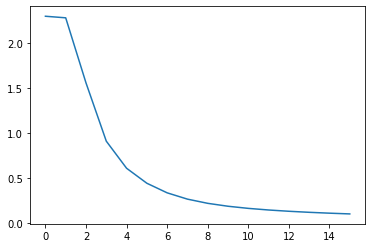

In [ ]:
n_features = X_train.shape[1]
n_classes = len(np.unique(y_train))
n_hidden = 30
model = NeuralNet(n_features, n_hidden, n_classes)
losses, accuracies, accuracies_test = [], [], []
losses.append(model.loss(X_train, y_train))
accuracies.append(model.accuracy(X_train, y_train))
accuracies_test.append(model.accuracy(X_test, y_test))

print("Random init: train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
      % (losses[-1], accuracies[-1], accuracies_test[-1]))

for epoch in range(15):
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        model.train(x, y, 0.01)

    losses.append(model.loss(X_train, y_train))
    accuracies.append(model.accuracy(X_train, y_train))
    accuracies_test.append(model.accuracy(X_test, y_test))
    print("Epoch #%d, train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
          % (epoch + 1, losses[-1], accuracies[-1], accuracies_test[-1]))
plt.plot(losses)

Text(0, 0.5, 'accuracy')

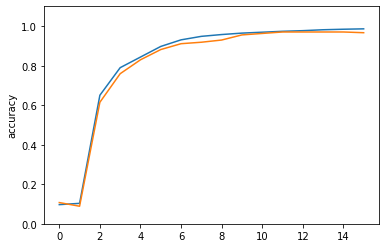

In [ ]:
plt.plot(accuracies, label='train')
plt.plot(accuracies_test, label='test')
plt.ylim(0, 1.1)
plt.ylabel("accuracy")

Random init: train loss: 2.30265, train acc: 0.099, test acc: 0.100
Epoch #1, train loss: 2.30214, train acc: 0.109, test acc: 0.063
Epoch #2, train loss: 2.24246, train acc: 0.125, test acc: 0.081
Epoch #3, train loss: 2.02389, train acc: 0.394, test acc: 0.333
Epoch #4, train loss: 1.83245, train acc: 0.413, test acc: 0.348
Epoch #5, train loss: 1.68948, train acc: 0.420, test acc: 0.356
Epoch #6, train loss: 1.58496, train acc: 0.430, test acc: 0.356
Epoch #7, train loss: 1.50776, train acc: 0.401, test acc: 0.326
Epoch #8, train loss: 1.44951, train acc: 0.400, test acc: 0.330
Epoch #9, train loss: 1.40449, train acc: 0.399, test acc: 0.330
Epoch #10, train loss: 1.36880, train acc: 0.401, test acc: 0.333
Epoch #11, train loss: 1.33984, train acc: 0.403, test acc: 0.333
Epoch #12, train loss: 1.31584, train acc: 0.405, test acc: 0.333
Epoch #13, train loss: 1.29560, train acc: 0.407, test acc: 0.333
Epoch #14, train loss: 1.27827, train acc: 0.407, test acc: 0.344
Epoch #15, train 

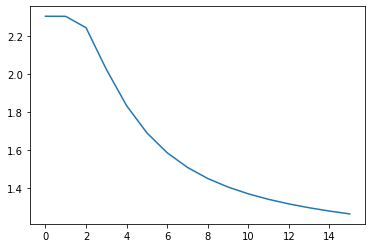

In [ ]:
n_features = X_train.shape[1]
n_classes = len(np.unique(y_train))
n_hidden = 2
model = NeuralNet(n_features, n_hidden, n_classes)
losses, accuracies, accuracies_test = [], [], []
losses.append(model.loss(X_train, y_train))
accuracies.append(model.accuracy(X_train, y_train))
accuracies_test.append(model.accuracy(X_test, y_test))

print("Random init: train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
      % (losses[-1], accuracies[-1], accuracies_test[-1]))

for epoch in range(15):
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        model.train(x, y, 0.01)

    losses.append(model.loss(X_train, y_train))
    accuracies.append(model.accuracy(X_train, y_train))
    accuracies_test.append(model.accuracy(X_test, y_test))
    print("Epoch #%d, train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
          % (epoch + 1, losses[-1], accuracies[-1], accuracies_test[-1]))
plt.plot(losses)

Text(0, 0.5, 'accuracy')

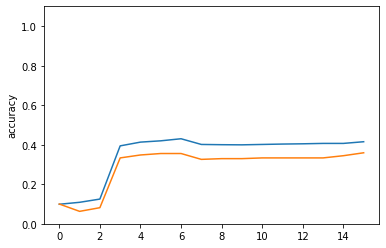

In [ ]:
plt.plot(accuracies, label='train')
plt.plot(accuracies_test, label='test')
plt.ylim(0, 1.1)
plt.ylabel("accuracy")

hidden=30
Увеличение размера скрытого слоя улучшило модель. Она стала более точной с меньшей ошибкой.
hidden=2
Малый размер слоев дает худше результаты. Большая ошибка и малая точность.

In [ ]:
EPSILON = 1e-8
class NeuralNet():
    """MLP с 1 скрытым слоем с сигмоидной активацией"""
    
    def __init__(self, input_size, hidden_size, output_size):
        # Ваше решение
        self.W_h = np.random.uniform(size=(input_size, hidden_size), high=0.01, low=-0.01)
        self.b_h = np.zeros(hidden_size)
        self.W_o = np.random.uniform(
            size=(hidden_size, output_size), high=0.01, low=-0.01)
        self.b_o = np.zeros(output_size)
        self.output_size = output_size
            
    def forward_keep_activations(self, X):
        # Ваше решение
        z_h = np.dot(X, self.W_h) + self.b_h
        h = sigmoid(z_h)
        z_o = np.dot(h, self.W_o) + self.b_o
        y = softmax(z_o)
        return y, h, z_h

    def forward(self, X):
        y, h, z_h = self.forward_keep_activations(X)
        return y

    def loss(self, X, y):
        # Ваше решение
        return nll(one_hot(self.output_size, y), self.forward(X))

    def grad_loss(self, x, y_true):
        # Ваше решение
        y, h, z_h = self.forward_keep_activations(x)
        grad_z_o = y - one_hot(self.output_size, y_true)

        grad_W_o = np.outer(h, grad_z_o)
        grad_b_o = grad_z_o
        grad_h = np.dot(grad_z_o, np.transpose(self.W_o))
        grad_z_h = grad_h * dsigmoid(z_h)
        grad_W_h = np.outer(x, grad_z_h)
        grad_b_h = grad_z_h
        return {"W_h": grad_W_h, "b_h": grad_b_h, "W_o": grad_W_o, "b_o": grad_b_o}

    def train(self, x, y, learning_rate):
        # Ваше решение
        grads = self.grad_loss(x, y)
        self.W_h = self.W_h - learning_rate * grads["W_h"]
        self.b_h = self.b_h - learning_rate * grads["b_h"]
        self.W_o = self.W_o - learning_rate * grads["W_o"]
        self.b_o = self.b_o - learning_rate * grads["b_o"]

    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)

Random init: train loss: 2.30255, train acc: 0.102, test acc: 0.096
Epoch #1, train loss: 2.29901, train acc: 0.109, test acc: 0.063
Epoch #2, train loss: 2.20622, train acc: 0.192, test acc: 0.152
Epoch #3, train loss: 2.02676, train acc: 0.320, test acc: 0.263
Epoch #4, train loss: 1.83803, train acc: 0.399, test acc: 0.330
Epoch #5, train loss: 1.68846, train acc: 0.399, test acc: 0.322
Epoch #6, train loss: 1.57681, train acc: 0.401, test acc: 0.330
Epoch #7, train loss: 1.49382, train acc: 0.403, test acc: 0.341
Epoch #8, train loss: 1.43128, train acc: 0.407, test acc: 0.344
Epoch #9, train loss: 1.38316, train acc: 0.410, test acc: 0.348
Epoch #10, train loss: 1.34498, train acc: 0.417, test acc: 0.363
Epoch #11, train loss: 1.31474, train acc: 0.423, test acc: 0.367
Epoch #12, train loss: 1.29012, train acc: 0.426, test acc: 0.374
Epoch #13, train loss: 1.26973, train acc: 0.431, test acc: 0.378
Epoch #14, train loss: 1.25259, train acc: 0.434, test acc: 0.378
Epoch #15, train 

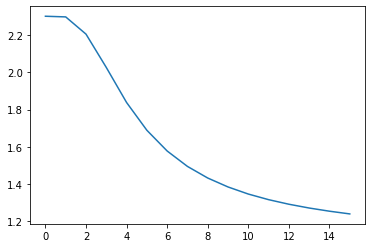

In [ ]:
n_features = X_train.shape[1]
n_classes = len(np.unique(y_train))
n_hidden = 2
model = NeuralNet(n_features, n_hidden, n_classes)
losses, accuracies, accuracies_test = [], [], []
losses.append(model.loss(X_train, y_train))
accuracies.append(model.accuracy(X_train, y_train))
accuracies_test.append(model.accuracy(X_test, y_test))

print("Random init: train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
      % (losses[-1], accuracies[-1], accuracies_test[-1]))

for epoch in range(15):
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        model.train(x, y, 0.01)

    losses.append(model.loss(X_train, y_train))
    accuracies.append(model.accuracy(X_train, y_train))
    accuracies_test.append(model.accuracy(X_test, y_test))
    print("Epoch #%d, train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
          % (epoch + 1, losses[-1], accuracies[-1], accuracies_test[-1]))
plt.plot(losses)

Text(0, 0.5, 'accuracy')

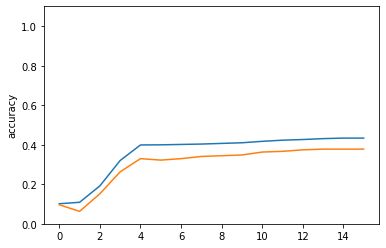

In [ ]:
plt.plot(accuracies, label='train')
plt.plot(accuracies_test, label='test')
plt.ylim(0, 1.1)
plt.ylabel("accuracy")

0 инициализация 
Модель обладает плохим качеттвом. Большая ошибка и малая точность.

In [ ]:
EPSILON = 1e-8
def relu(Z):
    R = np.maximum(0, Z)
    return R

class NeuralNet():
    """MLP с 1 скрытым слоем с сигмоидной активацией"""
    
    def __init__(self, input_size, hidden_size, output_size):
        # Ваше решение
        self.W_h = np.random.uniform(size=(input_size, hidden_size), high=0.01, low=-0.01)
        self.b_h = np.zeros(hidden_size)
        self.W_o = np.random.uniform(
            size=(hidden_size, output_size), high=0.01, low=-0.01)
        self.b_o = np.zeros(output_size)
        self.output_size = output_size
            
    def forward_keep_activations(self, X):
        # Ваше решение
        z_h = np.dot(X, self.W_h) + self.b_h
        h = sigmoid(z_h)
        z_o = np.dot(h, self.W_o) + self.b_o
        y = relu(z_o)
        return y, h, z_h

    def forward(self, X):
        h = sigmoid(np.dot(X, self.W_h) + self.b_h)
        y = relu(np.dot(h, self.W_o) + self.b_o)
        return y

    def loss(self, X, y):
        # Ваше решение
        return nll(one_hot(self.output_size, y), self.forward(X))

    def grad_loss(self, x, y_true):
        # Ваше решение
        y, h, z_h = self.forward_keep_activations(x)
        grad_z_o = y - one_hot(self.output_size, y_true)

        grad_W_o = np.outer(h, grad_z_o)
        grad_b_o = grad_z_o
        grad_h = np.dot(grad_z_o, np.transpose(self.W_o))
        grad_z_h = grad_h * dsigmoid(z_h)
        grad_W_h = np.outer(x, grad_z_h)
        grad_b_h = grad_z_h
        return {"W_h": grad_W_h, "b_h": grad_b_h, "W_o": grad_W_o, "b_o": grad_b_o}

    def train(self, x, y, learning_rate):
        # Ваше решение
        grads = self.grad_loss(x, y)
        self.W_h = self.W_h - learning_rate * grads["W_h"]
        self.b_h = self.b_h - learning_rate * grads["b_h"]
        self.W_o = self.W_o - learning_rate * grads["W_o"]
        self.b_o = self.b_o - learning_rate * grads["b_o"]

    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)

Random init: train loss: 12.99966, train acc: 0.102, test acc: 0.096
Epoch #1, train loss: 2.31689, train acc: 0.248, test acc: 0.244
Epoch #2, train loss: 1.55191, train acc: 0.571, test acc: 0.563
Epoch #3, train loss: 1.06091, train acc: 0.815, test acc: 0.781
Epoch #4, train loss: 0.76196, train acc: 0.847, test acc: 0.811
Epoch #5, train loss: 0.55337, train acc: 0.868, test acc: 0.826
Epoch #6, train loss: 0.43189, train acc: 0.910, test acc: 0.878
Epoch #7, train loss: 0.36290, train acc: 0.936, test acc: 0.911
Epoch #8, train loss: 0.31149, train acc: 0.955, test acc: 0.926
Epoch #9, train loss: 0.27759, train acc: 0.965, test acc: 0.926
Epoch #10, train loss: 0.26050, train acc: 0.969, test acc: 0.937
Epoch #11, train loss: 0.24205, train acc: 0.972, test acc: 0.944
Epoch #12, train loss: 0.22754, train acc: 0.975, test acc: 0.948
Epoch #13, train loss: 0.21578, train acc: 0.977, test acc: 0.952
Epoch #14, train loss: 0.19907, train acc: 0.977, test acc: 0.952
Epoch #15, train

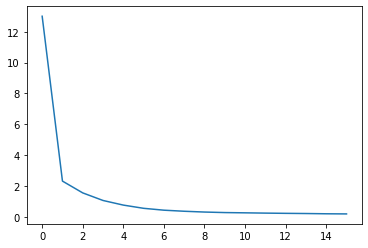

In [ ]:
# lr = 0.01

n_features = X_train.shape[1]
n_classes = len(np.unique(y_train))
n_hidden = 10
model = NeuralNet(n_features, n_hidden, n_classes)
losses, accuracies, accuracies_test = [], [], []
losses.append(model.loss(X_train, y_train))
accuracies.append(model.accuracy(X_train, y_train))
accuracies_test.append(model.accuracy(X_test, y_test))

print("Random init: train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
      % (losses[-1], accuracies[-1], accuracies_test[-1]))

for epoch in range(15):
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        model.train(x, y, 0.01)

    losses.append(model.loss(X_train, y_train))
    accuracies.append(model.accuracy(X_train, y_train))
    accuracies_test.append(model.accuracy(X_test, y_test))
    print("Epoch #%d, train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
          % (epoch + 1, losses[-1], accuracies[-1], accuracies_test[-1]))
plt.plot(losses)

Text(0, 0.5, 'accuracy')

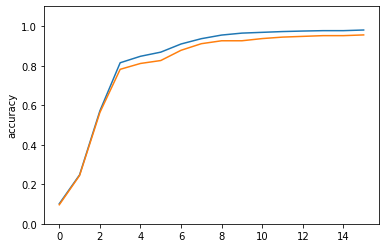

In [ ]:
plt.plot(accuracies, label='train')
plt.plot(accuracies_test, label='test')
plt.ylim(0, 1.1)
plt.ylabel("accuracy")

Использование Активации relu с Learning rait=0.01 дает хорошую точноть модели с низкой ошибкой, однко другие параметры могут улучщить резултаты.

Работа с Keras

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

n_features = 8 * 8
n_classes = 10
n_hidden = 10

keras_model = Sequential()
keras_model.add(Dense(n_hidden, input_dim=n_features, activation='sigmoid'))
keras_model.add(Dense(n_classes, activation='softmax'))

keras_model.compile(optimizer=SGD(lr=3),
                    loss='categorical_crossentropy', metrics=['accuracy'])

keras_model.fit(X_train, to_categorical(y_train), epochs=15, batch_size=32);

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/15
48/48 [==============================] - 1s 2ms/step - loss: 0.8468 - accuracy: 0.7531
Epoch 2/15
48/48 [==============================] - 0s 2ms/step - loss: 0.2213 - accuracy: 0.9476
Epoch 3/15
48/48 [==============================] - 0s 3ms/step - loss: 0.1496 - accuracy: 0.9620
Epoch 4/15
48/48 [==============================] - 0s 2ms/step - loss: 0.1292 - accuracy: 0.9673
Epoch 5/15
48/48 [==============================] - 0s 2ms/step - loss: 0.0905 - accuracy: 0.9823
Epoch 6/15
48/48 [==============================] - 0s 2ms/step - loss: 0.0802 - accuracy: 0.9817
Epoch 7/15
48/48 [==============================] - 0s 2ms/step - loss: 0.0685 - accuracy: 0.9849
Epoch 8/15
48/48 [==============================] - 0s 2ms/step - loss: 0.0567 - accuracy: 0.9882
Epoch 9/15
48/48 [==============================] - 0s 2ms/step - loss: 0.0465 - accuracy: 0.9908
Epoch 10/15
48/48 [==============================] - 0s 2ms/step - loss: 0.0441 - accuracy: 0.9915
Epoch 11/15
48/48 [

Text(0.5, 1.0, 'true label: 8')

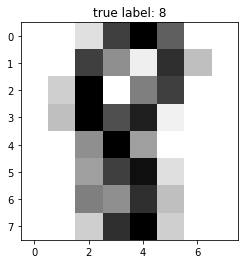

In [ ]:
sample_idx = 42
plt.imshow(scaler.inverse_transform(X_test[[sample_idx]]).reshape(8, 8), cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("true label: %d" % y_test[sample_idx])

In [ ]:
probabilities = keras_model.predict(X_test, verbose=0)
for class_idx, prob in enumerate(probabilities[sample_idx]):
    print("%d: %0.5f" % (class_idx, prob))

0: 0.00001
1: 0.00045
2: 0.00001
3: 0.00000
4: 0.00296
5: 0.00002
6: 0.00007
7: 0.00000
8: 0.99645
9: 0.00004


In [ ]:
y_pred=[]
for i in range(len(X_test)):
  y_pred.append(np.argmax(keras_model.predict(X_test[[i]], verbose=0)))


Text(0.5, 15.0, 'Предсказанные значения')

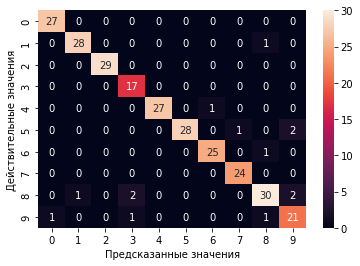

In [ ]:
import numpy as np; np.random.seed(0)
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix
sns.heatmap(pd.DataFrame(
   confusion_matrix(y_test, y_pred)),
    annot=True)
plt.ylabel('Действительные значения')
plt.xlabel('Предсказанные значения')

Можно увидеть что практически всегда модель дает верные предсказания, что говорит о хорошем качестве модели.